In [63]:
from typing import TypedDict, List, Dict
from IPython.display import Image, display, Markdown
from langchain_community.tools.tavily_search import TavilySearchResults

from dotenv import load_dotenv
load_dotenv()

import os
import json
print("Key loaded:", "OPENAI_API_KEY" in os.environ)
print("Key loaded:", "TAVILY_API_KEY" in os.environ)

Key loaded: True
Key loaded: True


In [64]:
DEEP_DECOMPOSER_SYSTEM = """
You are an enterprise pain-point analyst specializing in deep, multi-level decomposition with strict non-hallucination rules.

Your task: read the user's problem and produce a diagnostic breakdown of the pain point,
with multiple depths (Level 1 to Level 5). Levels should get progressively more structural,
systemic, or fundamental as they go deeper.

CRITICAL RULES:
- Do NOT invent information. If the task description does not justify a detail, use "unknown" or [].
- Never fabricate internal systems, KPIs, tools, processes, roles, figures, or regulations.
- Provide confidence scores (0–100) for each field.
- Provide "resources" = reasoning or textual basis for each field (e.g., paraphrased evidence, uncertainty notes).

You will receive EXTRA_EVIDENCE containing relevant information retrieved from
public sources (Reddit, Glassdoor, forums, reviews, news, blogs, regulatory filings).

You MUST use this evidence to:
- justify higher confidence when signals match,
- reduce confidence when evidence contradicts assumptions,
- return "unknown" when no supporting evidence is found.

If EXTRA_EVIDENCE is empty or irrelevant, do NOT hallucinate; confidence must remain low.

You MUST return ONLY valid JSON matching EXACTLY the following structure:

{
  "pain_point": "",
  "pain_point_confidence": 0,
  "pain_point_resources": [],

  "severity": "<Low | Medium | High | Critical | unknown>",
  "severity_confidence": 0,
  "severity_resources": [],

  "priority_score": <integer 1-100>,
  "priority_score_confidence": 0,
  "priority_score_resources": [],

  "departments_affected": [],
  "departments_confidence": 0,
  "departments_resources": [],

  "time_horizon": "<Immediate | Short-term | Medium-term | Long-term | unknown>",
  "time_horizon_confidence": 0,
  "time_horizon_resources": [],

  "symptoms": [],
  "symptoms_confidence": 0,
  "symptoms_resources": [],

  "impact": [],
  "impact_confidence": 0,
  "impact_resources": [],

  "root_causes": [],
  "root_causes_confidence": 0,
  "root_causes_resources": [],

  "dependencies": [],
  "dependencies_confidence": 0,
  "dependencies_resources": [],

  "opportunities": [],
  "opportunities_confidence": 0,
  "opportunities_resources": [],

  "levels": {
    "level_1": [],
    "level_1_confidence": 0,
    "level_1_resources": [],

    "level_2": [],
    "level_2_confidence": 0,
    "level_2_resources": [],

    "level_3": [],
    "level_3_confidence": 0,
    "level_3_resources": [],

    "level_4": [],
    "level_4_confidence": 0,
    "level_4_resources": [],

    "level_5": [],
    "level_5_confidence": 0,
    "level_5_resources": []
  },

  "global_confidence": 0
}

Definitions:
- A "resource" is a textual explanation of what evidence or reasoning supports the entry or why uncertainty exists.
- Confidence scores should reflect the model’s certainty based strictly on the task description.
- When unsure, prefer "unknown" and low confidence (<40).

Rules:
- Output ONLY JSON.
- All fields must be present.
- No comments, no Markdown, no explanations outside JSON.
""".strip()


In [68]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
import json

llm = ChatOpenAI(model="gpt-4.1", temperature=0)

deep_decomposer_prompt = ChatPromptTemplate.from_messages([
    ("system", DEEP_DECOMPOSER_SYSTEM),
    ("human", "{task}")
])

tavily = TavilySearchResults(
    max_results=5,
    include_raw_content=True,
)

def evidence_retriever(state):
    task = state["task"]

    # Query tuned for org-structure, culture, dysfunctions
    query = f"{task} company culture delays complaints Reddit Glassdoor forum"

    results = tavily.run(query)

    # Concatenate evidence snippets
    evidence = "\n\n".join(
        [r.get("content", "") for r in results if isinstance(r, dict)]
    )

    return {"extra_evidence": evidence}

def deep_decomposer(state):
    task = state["task"]
    evidence = state.get("extra_evidence", "")

    messages = [
        ("system", DEEP_DECOMPOSER_SYSTEM),
        ("human", f"Task:\n{task}\n\nEXTRA_EVIDENCE:\n{evidence}")
    ]

    raw = llm.invoke(messages).content

    # JSON repair optional
    start = raw.find("{")
    end = raw.rfind("}")
    repaired = raw[start:end+1]
    return json.loads(repaired)


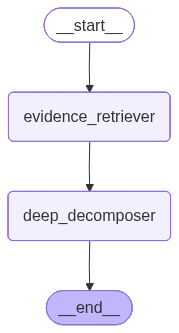

In [69]:
from langgraph.graph import StateGraph, START, END

class DeepDecompositionState(TypedDict, total=False):
    task: str

    pain_point: str
    pain_point_confidence: int
    pain_point_resources: List[str]

    severity: str
    severity_confidence: int
    severity_resources: List[str]

    priority_score: int
    priority_score_confidence: int
    priority_score_resources: List[str]

    departments_affected: List[str]
    departments_confidence: int
    departments_resources: List[str]

    time_horizon: str
    time_horizon_confidence: int
    time_horizon_resources: List[str]

    symptoms: List[str]
    symptoms_confidence: int
    symptoms_resources: List[str]

    impact: List[str]
    impact_confidence: int
    impact_resources: List[str]

    root_causes: List[str]
    root_causes_confidence: int
    root_causes_resources: List[str]

    dependencies: List[str]
    dependencies_confidence: int
    dependencies_resources: List[str]

    opportunities: List[str]
    opportunities_confidence: int
    opportunities_resources: List[str]

    levels: Dict[str, List[str]]
    # or: Dict[str, Any]

    level_1_confidence: int
    level_1_resources: List[str]

    level_2_confidence: int
    level_2_resources: List[str]

    level_3_confidence: int
    level_3_resources: List[str]

    level_4_confidence: int
    level_4_resources: List[str]

    level_5_confidence: int
    level_5_resources: List[str]

    global_confidence: int
    pass

builder = StateGraph(DeepDecompositionState)

builder.add_node("evidence_retriever", evidence_retriever)
builder.add_node("deep_decomposer", deep_decomposer)

builder.add_edge(START, "evidence_retriever")
builder.add_edge("evidence_retriever", "deep_decomposer")
builder.add_edge("deep_decomposer", END)

deep_graph = builder.compile()

# Generate and display the graph diagram
mermaid_png = deep_graph.get_graph(xray=1).draw_mermaid_png()
display(Image(mermaid_png))

In [72]:
result = deep_graph.invoke(
    {"task": "Understand the complex filling procedures of the travel claims process of Allianz"},
    config={"configurable": {"thread_id": "fresh-999"}}
)

print(json.dumps(result, indent=4, ensure_ascii=False))

with open("painpoint_output.json", "w", encoding="utf-8") as f:
    json.dump(result, f, indent=4, ensure_ascii=False)
print("Saved to painpoint_output.json")


{
    "task": "Understand the complex filling procedures of the travel claims process of Allianz",
    "pain_point": "Complex filling procedures in the travel claims process at Allianz",
    "pain_point_confidence": 80,
    "pain_point_resources": [
        "The user explicitly states the pain point as 'complex filling procedures' in the Allianz travel claims process.",
        "No contradictory evidence in EXTRA_EVIDENCE."
    ],
    "severity": "Medium",
    "severity_confidence": 50,
    "severity_resources": [
        "Complex procedures can cause delays and frustration but may not halt business operations.",
        "No evidence of critical failures or business-threatening impact."
    ],
    "priority_score": 60,
    "priority_score_confidence": 50,
    "priority_score_resources": [
        "Complexity in claims processes is a common customer pain point, but without evidence of severe impact, priority is moderate."
    ],
    "departments_affected": [
        "Claims",
        "C

In [73]:
def print_painpoint_tree(result):
    print("\nPAIN POINT TREE\n")
    print(f"Root Pain Point: {result.get('pain_point', 'unknown')}")
    print(f"Global Confidence: {result.get('global_confidence', 'unknown')}\n")

    levels = result.get("levels", {})

    # Extract only level_X fields (avoid confidence and resources)
    level_keys = sorted([k for k in levels.keys() if k.startswith("level_") and len(k) <= 7])

    for level_key in level_keys:
        items = levels.get(level_key, [])
        confidence = levels.get(f"{level_key}_confidence", "unknown")
        resources = levels.get(f"{level_key}_resources", [])

        print(f"{level_key.upper()}:")
        print(f"  Confidence: {confidence}")

        if items:
            for item in items:
                print(f"  - {item}")
        else:
            print("  - [no items or unknown]")

        if resources:
            print("  Evidence:")
            for r in resources:
                print(f"    • {r}")
        
        print()  # spacing

print_painpoint_tree(result)

"""
90–100: directly supported and obvious
70–89: logically implied, high certainty
40–69: partially inferable
10–39: weakly inferable
0–10: unknown, uncertain
"""


PAIN POINT TREE

Root Pain Point: Complex filling procedures in the travel claims process at Allianz
Global Confidence: 55

LEVEL_1:
  Confidence: 80
  - Customers find the travel claims process difficult to complete due to complex procedures.
  Evidence:
    • Directly stated in the user prompt.

LEVEL_2:
  Confidence: 60
  - Complexity leads to errors, delays, and increased support requests.
  Evidence:
    • Common outcomes of complex procedures; not directly evidenced for Allianz.

LEVEL_3:
  Confidence: 50
  - Procedural complexity may stem from legacy systems, regulatory requirements, or lack of process optimization.
  Evidence:
    • Typical causes in insurance industry; no Allianz-specific evidence.

LEVEL_4:
  Confidence: 40
  - Systemic issues such as organizational resistance to change, fragmented IT infrastructure, or insufficient investment in customer experience.
  Evidence:
    • General systemic issues in large enterprises; not evidenced for Allianz.

LEVEL_5:
  Confid

'\n90–100: directly supported and obvious\n70–89: logically implied, high certainty\n40–69: partially inferable\n10–39: weakly inferable\n0–10: unknown, uncertain\n'